In [4]:
import os, sys, random, pandas as pd, numpy as np
from tqdm import tqdm
import torch


# set random seed
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
sys.path.append('../')


# load package requirments
from VGFM.utils import  generate_steps, parser, _valid_criterions
from VGFM.plots import plot_comparision
from VGFM.train import pretrain, train
from VGFM.models import  FNet, ODEFunc2
from VGFM.constants import DATA_DIR
from VGFM.exp import setup_exp
from VGFM.eval import generate_plot_data
from torchdiffeq import odeint_adjoint as odeint

### Defining parameters and loading dataset

In [5]:
import torch.optim as optim

dim=50
f_net = FNet(in_out_dim=dim, hidden_dim=256, n_hiddens=5, activation='leakyrelu')

import sys

# Simulate the command-line arguments
sys.argv = [
    'VGFM Training',
    '-d', 'file',
    '-c', 'ot1',
    '-n', 'eb_final',
    '--no-hold-one-out',
    '-ho', '-1',
    '-e1', '2000',
    '-e2', '30',
    '-bs', '256',
    '-r', '0.01',
    '-rm', '5',
    '--norm_cost'
]

args = parser.parse_args()
opts = vars(args)

# Display the parsed arguments
print(opts)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


{'dataset': 'file', 'time_col': None, 'name': 'eb_final', 'output_dir': 'd:\\NeurIPS_2025_VGFM\\VGFM\\results', 'criterion': 'ot1', 'sample_with_replacement': False, 'hold_one_out': False, 'hold_out': -1, 'apply_losses_in_time': True, 'learning_rate1': 0.001, 'epochs1': 2000, 'norm_cost': True, 'reg': 0.01, 'reg_m': 5.0, 'n_big_batches': 1, 'n_batch': 256, 'learning_rate2': 0.0001, 'epochs2': 30}


device(type='cpu')

In [ ]:
df = pd.read_csv(DATA_DIR + '/eb_pca50.csv')
df=df.iloc[:,:dim+1]
 # make output dir
if not os.path.isdir(opts['output_dir']):
    os.makedirs(opts['output_dir'])
exp_dir, logger = setup_exp(opts['output_dir'], opts, opts['name'])
  # load dataset
logger.info(f'Loading dataset: '+opts['name'])


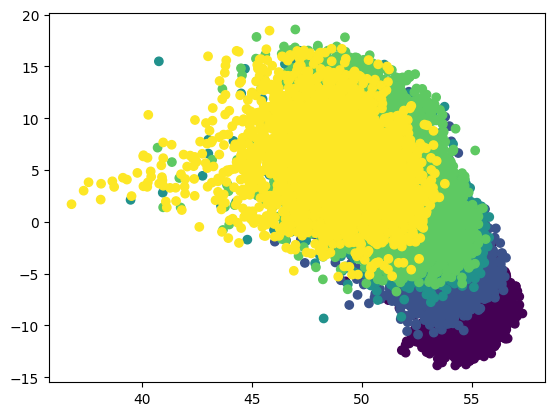

In [7]:
import matplotlib.pyplot as plt
plt.scatter(df.iloc[:,1],df.iloc[:,2],c=df.iloc[:,0])

In [8]:
groups = sorted([g for g in df.samples.unique() if g != args.hold_out])
steps = generate_steps(groups)
optimizer = torch.optim.Adam(f_net.parameters())
opts['criterion']='ot1'
criterion =  _valid_criterions[opts['criterion']]()

# # logger.info(f'Extracting parameters')
use_cuda = torch.cuda.is_available()
# sample_with_replacement = opts['sample_with_replacement' ]
# apply_losses_in_time = opts['apply_losses_in_time']

    
local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
batch_losses = []
globe_losses = []

In [9]:
f_net=f_net.to(device)

In [10]:
initial_size=df[df['samples']==0].x1.shape[0]
initial_size

2381

In [11]:
sample_sizes = df.groupby('samples').size()
ref0 = sample_sizes / sample_sizes.iloc[0]  
relative_mass = torch.tensor(ref0.values) 
relative_mass

tensor([1.0000, 1.7484, 1.3767, 1.5393, 1.3994], dtype=torch.float64)

In [12]:
sample_size = (df[df['samples']==0.0].values.shape[0],)

### Training with $\mathcal{L}_{\rm VGFM}$

In [13]:
f_net, v_losses, g_losses, losses = pretrain(
    f_net,
    df,
    optimizer,
    n_epoch=args.epochs1,
    hold_out=args.hold_out,
    logger=logger,
    relative_mass=relative_mass,
    reg=args.reg,
    reg_m=[args.reg_m, np.inf],
    norm_cost=args.norm_cost,
    batch_size=args.n_batch
)


relative_mass tensor([1.0000, 1.7484, 1.3767, 1.5393, 1.3994], dtype=torch.float64)
t_train: [0, 1, 2, 3, 4]


Begin flow and growth matching...: 100%|██████████| 2000/2000 [02:27<00:00, 13.60epoch/s, loss=2.177453, vloss=2.177417, gloss=0.000036]


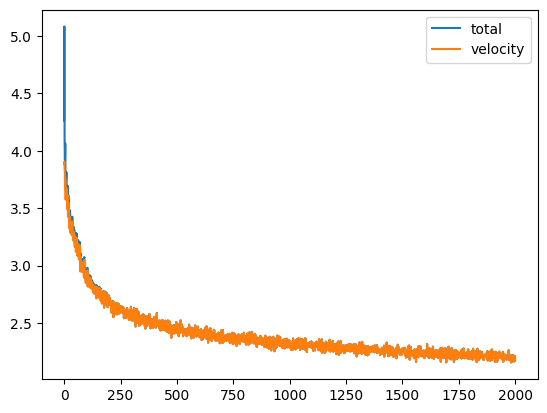

In [14]:
import matplotlib.pyplot as plt
plt.plot(losses,label='total')
plt.plot(v_losses,label='velocity')
# plt.plot(g_losses,label='growth')
plt.legend()

In [15]:
torch.save(f_net.state_dict(), os.path.join(exp_dir+'/pretrain_best_model'))

In [16]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/pretrain_best_model'),map_location=torch.device('cpu')))
optimizer = torch.optim.Adam(f_net.parameters(),lr=args.learning_rate2)

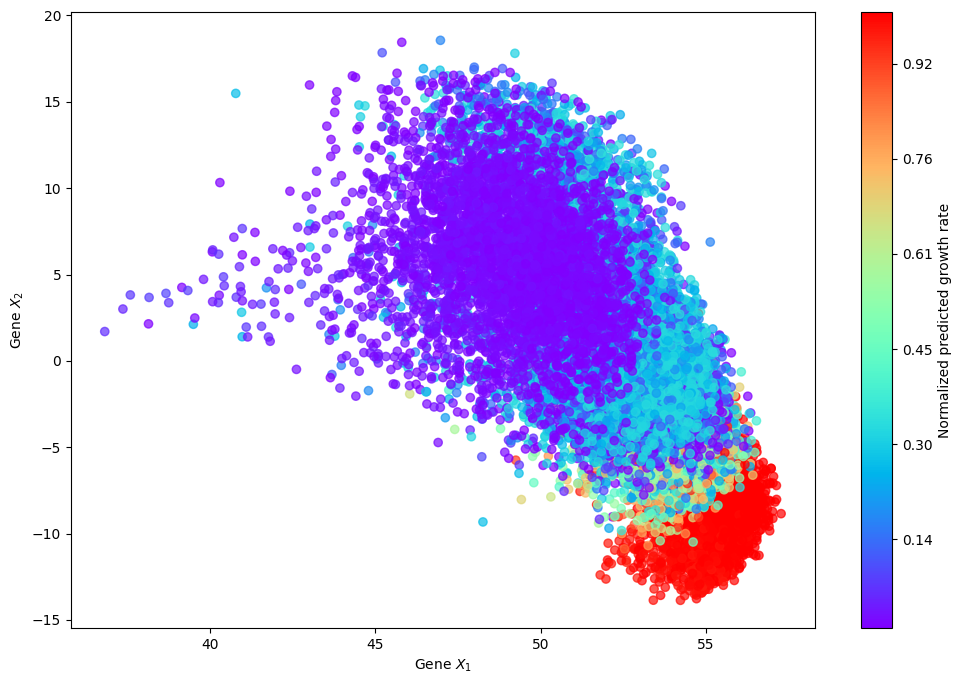

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 50

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_pretrain.pdf')

In [18]:
# generate plot data
f_net.to('cpu')
generated, trajectories,_,_ = generate_plot_data(
    f_net, df, n_points=400, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3., 4.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0404, 0.0808, 0.1212, 0.1616, 0.2020, 0.2424, 0.2828, 0.3232,
        0.3636, 0.4040, 0.4444, 0.4848, 0.5253, 0.5657, 0.6061, 0.6465, 0.6869,
        0.7273, 0.7677, 0.8081, 0.8485, 0.8889, 0.9293, 0.9697, 1.0101, 1.0505,
        1.0909, 1.1313, 1.1717, 1.2121, 1.2525, 1.2929, 1.3333, 1.3737, 1.4141,
        1.4545, 1.4949, 1.5354, 1.5758, 1.6162, 1.6566, 1.6970, 1.7374, 1.7778,
        1.8182, 1.8586, 1.8990, 1.9394, 1.9798, 2.0202, 2.0606, 2.1010, 2.1414,
        2.1818, 2.2222, 2.2626, 2.3030, 2.3434, 2.3838, 2.4242, 2.4646, 2.5051,
        2.5455, 2.5859, 2.6263, 2.6667, 2.7071, 2.7475, 2.7879, 2.8283, 2.8687,
        2.9091, 2.9495, 2.9899, 3.0303, 3.0707, 3.1111, 3.1515, 3.1919, 3.2323,
        3.2727, 3.3131, 3.3535, 3.3939, 3.4343, 3.4747, 3.5152, 3.5556, 3.5960,
        3.6364, 3.6768, 3.7172, 3.7576, 3.7980, 3.8384, 3.8788, 3.9192, 3.9596,
        4.0000])
<class 'torch.Tensor'>


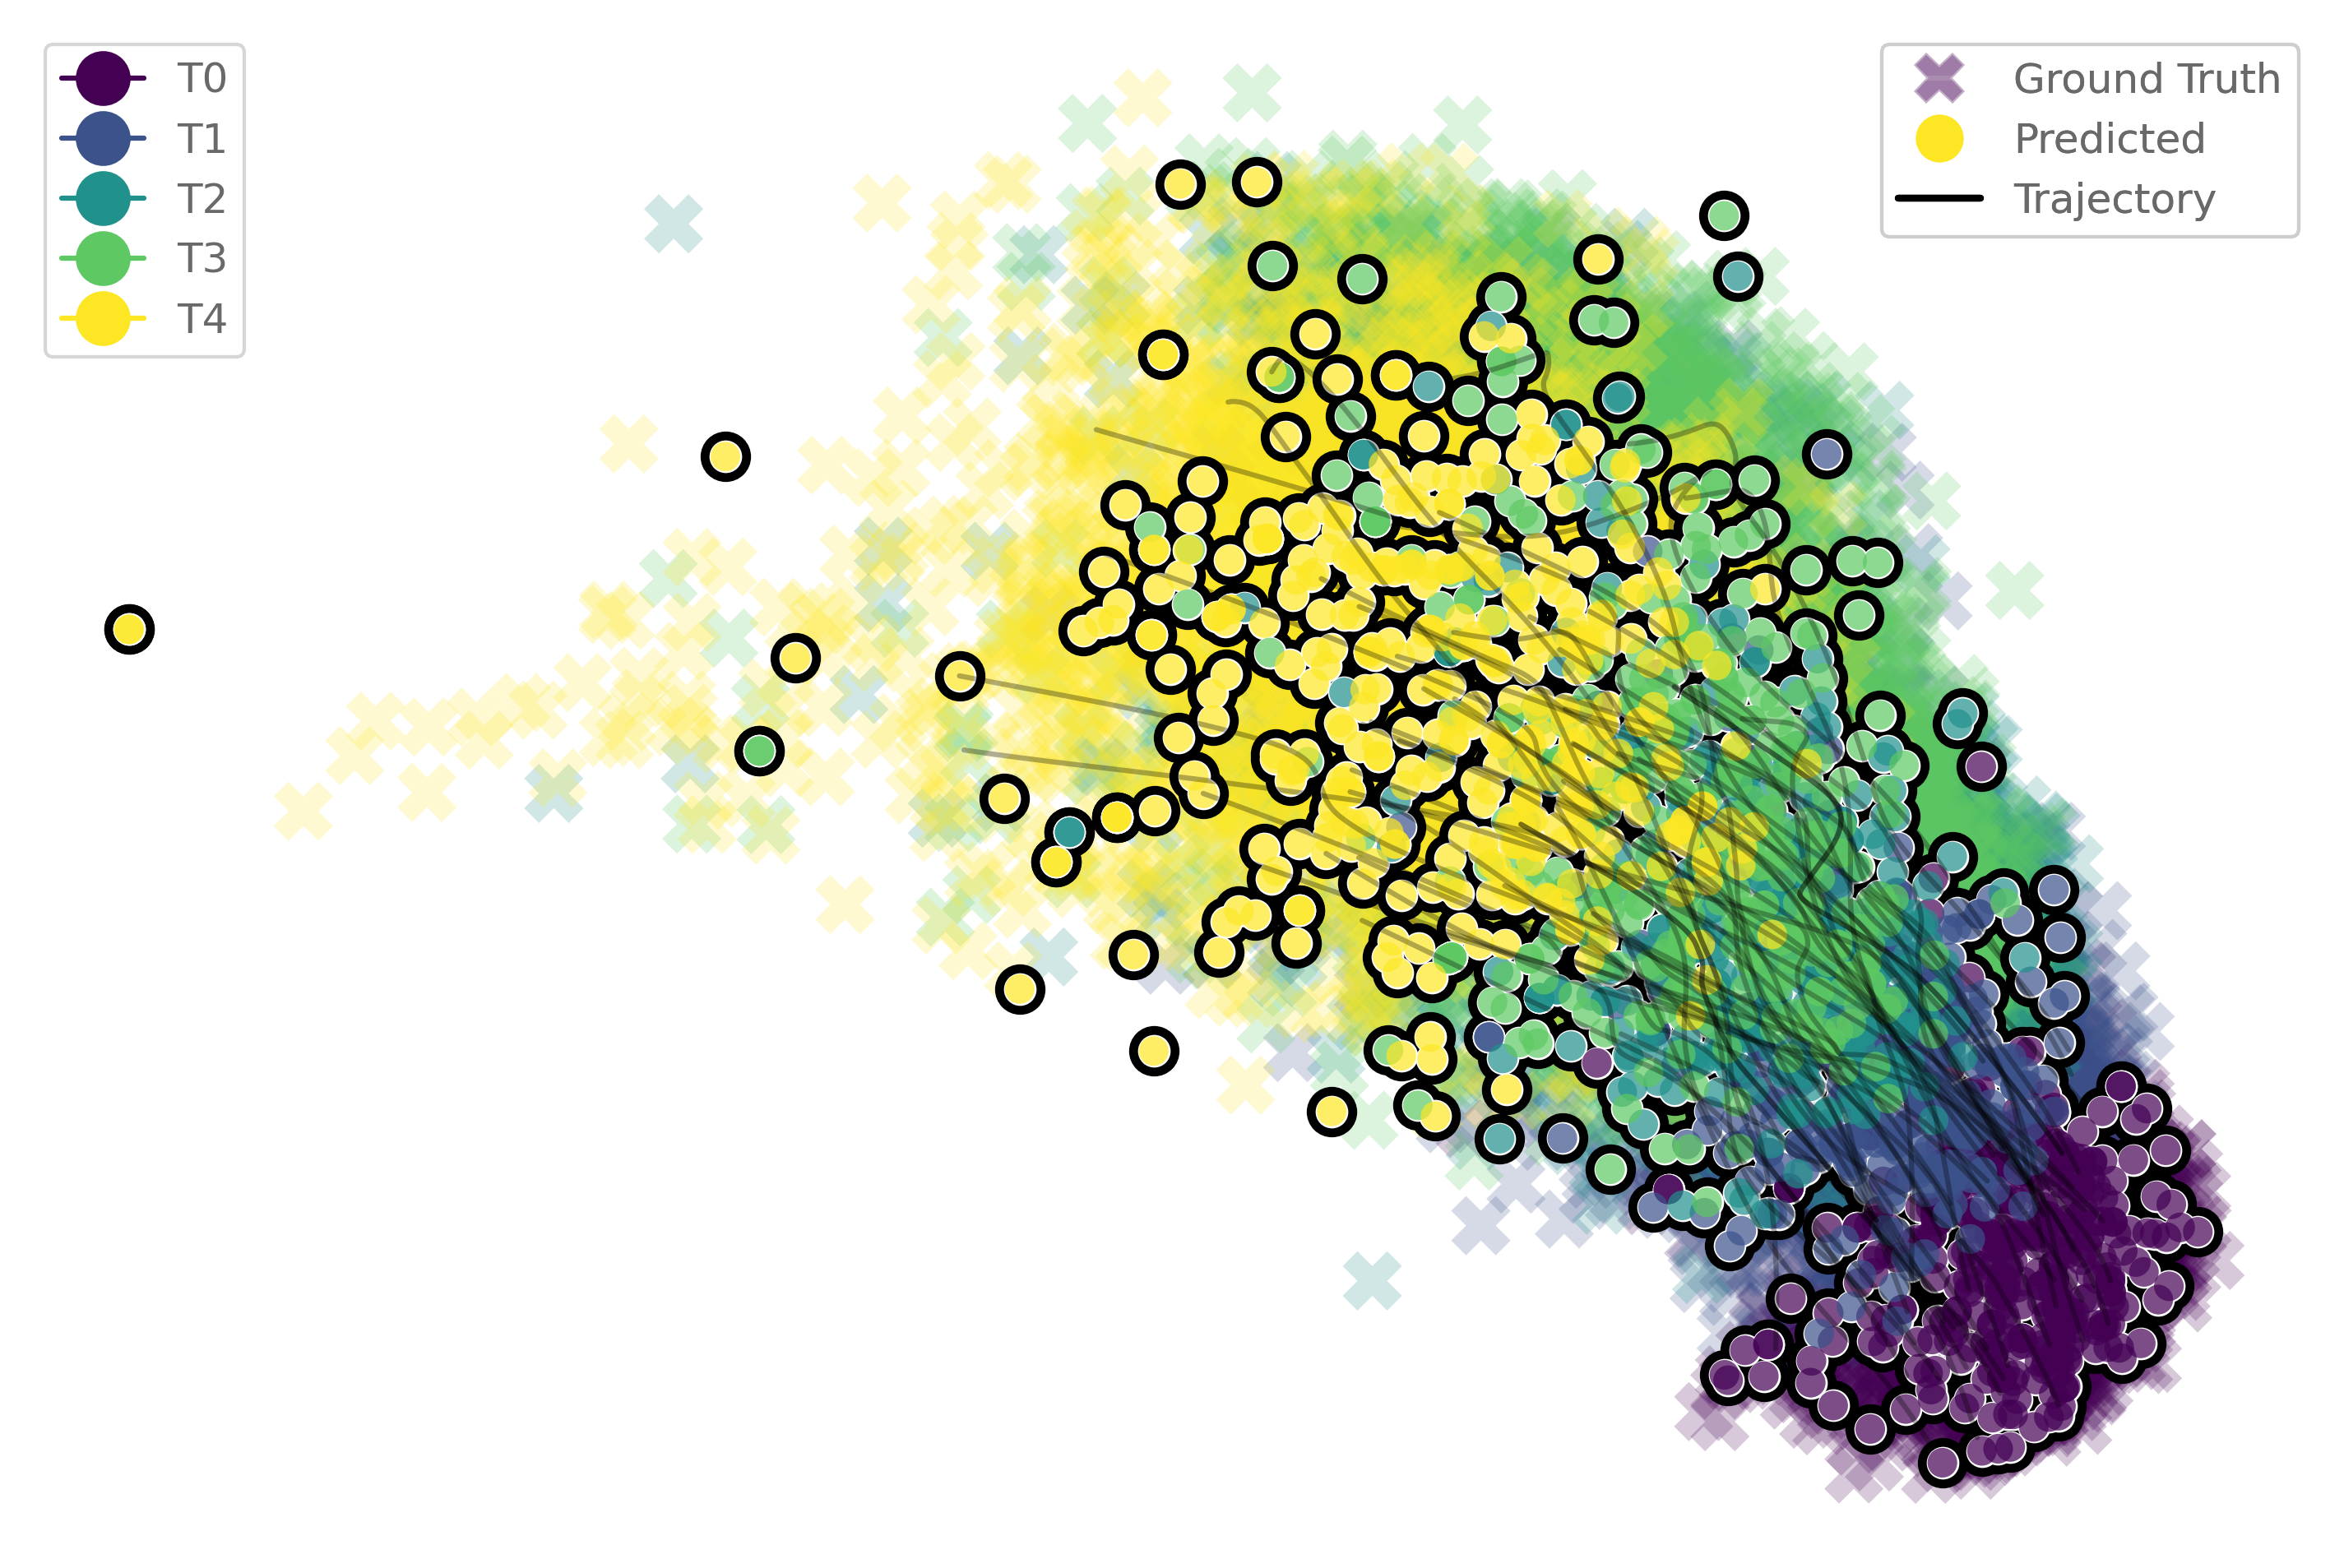

In [19]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_pretrain.png',
    x='x1', y='x2', is_3d=False
)

### Incorporating $\mathcal{L}_{\rm OT}$

In [20]:
logger.info("Incorporating $L_{ot}$")

# 训练阶段
l_loss, b_loss, g_loss = train(
    f_net,
    df,
    groups,
    optimizer,
    args.epochs2,  # n_epoch
    criterion=criterion,
    use_cuda=use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out,
    hold_out=args.hold_out,
    sample_size=sample_size,
    relative_mass=relative_mass,
    initial_size=initial_size,
    sample_with_replacement=args.sample_with_replacement,
    logger=logger,
    device=device,
    best_model_path=exp_dir + "/best_model",
    stepsize=0.1,
)

# 累积损失
for k, v in l_loss.items():
    local_losses[k].extend(v)

batch_losses.extend(b_loss)
globe_losses.extend(g_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:1.7168872356414795,relative_mass_now:1.7484250314993701
RME:0.01803783135662685
Otloss:8.81064
total loss:8.81064
epoch_0_1:
relative_mass_pred:1.5123902559280396,relative_mass_now:1.376732465350693
RME:0.09853605837848148
Otloss:10.1805
total loss:10.1805
epoch_0_2:
relative_mass_pred:1.6203218698501587,relative_mass_now:1.5392692146157076
RME:0.05265658174985755
Otloss:10.2644
total loss:10.2644
epoch_0_3:
relative_mass_pred:1.5306841135025024,relative_mass_now:1.3994120117597648
RME:0.09380518434857692


d:\NeurIPS_2025_VGFM\VGFM\notebooks\..\VGFM\train.py:200: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  batch_loss = torch.Tensor(batch_loss).float()
  3%|▎         | 1/30 [00:05<02:47,  5.78s/it]

Otloss:10.9241
total loss:10.9241
New minimum otloss found: 10.924144744873047. Model saved.
epoch_1_0:
relative_mass_pred:1.683861494064331,relative_mass_now:1.7484250314993701
RME:0.03692668331319433
Otloss:8.52561
total loss:8.52561
epoch_1_1:
relative_mass_pred:1.4524264335632324,relative_mass_now:1.376732465350693
RME:0.05498088417146325
Otloss:10.2082
total loss:10.2082
epoch_1_2:
relative_mass_pred:1.5946099758148193,relative_mass_now:1.5392692146157076
RME:0.035952620031401074
Otloss:11.3783
total loss:11.3783
epoch_1_3:
relative_mass_pred:1.4998881816864014,relative_mass_now:1.3994120117597648
RME:0.07179884771768356


  7%|▋         | 2/30 [00:12<02:49,  6.05s/it]

Otloss:11.7903
total loss:11.7903
epoch_2_0:
relative_mass_pred:1.6822577714920044,relative_mass_now:1.7484250314993701
RME:0.03784392170971362
Otloss:8.45235
total loss:8.45235
epoch_2_1:
relative_mass_pred:1.4419748783111572,relative_mass_now:1.376732465350693
RME:0.04738931826078874
Otloss:9.74301
total loss:9.74301
epoch_2_2:
relative_mass_pred:1.5747098922729492,relative_mass_now:1.5392692146157076
RME:0.023024352933667717
Otloss:10.0051
total loss:10.0051
epoch_2_3:
relative_mass_pred:1.484474778175354,relative_mass_now:1.3994120117597648
RME:0.06078464790981928


 10%|█         | 3/30 [00:17<02:41,  5.96s/it]

Otloss:10.5877
total loss:10.5877
New minimum otloss found: 10.58774185180664. Model saved.
epoch_3_0:
relative_mass_pred:1.69106125831604,relative_mass_now:1.7484250314993701
RME:0.032808826315039376
Otloss:8.30258
total loss:8.30258
epoch_3_1:
relative_mass_pred:1.4571980237960815,relative_mass_now:1.376732465350693
RME:0.058446764691418636
Otloss:9.74329
total loss:9.74329
epoch_3_2:
relative_mass_pred:1.585950493812561,relative_mass_now:1.5392692146157076
RME:0.030326910168542404
Otloss:10.105
total loss:10.105
epoch_3_3:
relative_mass_pred:1.4987181425094604,relative_mass_now:1.3994120117597648
RME:0.07096275429622607


 13%|█▎        | 4/30 [00:23<02:32,  5.87s/it]

Otloss:10.3182
total loss:10.3182
New minimum otloss found: 10.318220138549805. Model saved.
epoch_4_0:
relative_mass_pred:1.6977237462997437,relative_mass_now:1.7484250314993701
RME:0.028998260884052513
Otloss:8.26567
total loss:8.26567
epoch_4_1:
relative_mass_pred:1.4728552103042603,relative_mass_now:1.376732465350693
RME:0.06981948008982422
Otloss:9.42966
total loss:9.42966
epoch_4_2:
relative_mass_pred:1.6017444133758545,relative_mass_now:1.5392692146157076
RME:0.04058757114540509
Otloss:9.80428
total loss:9.80428
epoch_4_3:
relative_mass_pred:1.5097100734710693,relative_mass_now:1.3994120117597648
RME:0.07881743245336616


 17%|█▋        | 5/30 [00:29<02:24,  5.79s/it]

Otloss:10.3541
total loss:10.3541
epoch_5_0:
relative_mass_pred:1.7005599737167358,relative_mass_now:1.7484250314993701
RME:0.027376099586945042
Otloss:8.22097
total loss:8.22097
epoch_5_1:
relative_mass_pred:1.4788744449615479,relative_mass_now:1.376732465350693
RME:0.074191596538574
Otloss:9.237
total loss:9.237
epoch_5_2:
relative_mass_pred:1.6093108654022217,relative_mass_now:1.5392692146157076
RME:0.04550318431724145
Otloss:9.68419
total loss:9.68419
epoch_5_3:
relative_mass_pred:1.513381004333496,relative_mass_now:1.3994120117597648
RME:0.08144062764647483


 20%|██        | 6/30 [00:34<02:16,  5.70s/it]

Otloss:10.3454
total loss:10.3454
epoch_6_0:
relative_mass_pred:1.7007662057876587,relative_mass_now:1.7484250314993701
RME:0.02725814653364999
Otloss:8.18859
total loss:8.18859
epoch_6_1:
relative_mass_pred:1.4771041870117188,relative_mass_now:1.376732465350693
RME:0.07290575633767617
Otloss:9.1454
total loss:9.1454
epoch_6_2:
relative_mass_pred:1.6095831394195557,relative_mass_now:1.5392692146157076
RME:0.0456800695656104
Otloss:9.64656
total loss:9.64656
epoch_6_3:
relative_mass_pred:1.5123622417449951,relative_mass_now:1.3994120117597648
RME:0.08071263433218287


 23%|██▎       | 7/30 [00:40<02:09,  5.64s/it]

Otloss:10.137
total loss:10.137
New minimum otloss found: 10.136982917785645. Model saved.
epoch_7_0:
relative_mass_pred:1.6985983848571777,relative_mass_now:1.7484250314993701
RME:0.028498017212361292
Otloss:8.13055
total loss:8.13055
epoch_7_1:
relative_mass_pred:1.4712140560150146,relative_mass_now:1.376732465350693
RME:0.06862741530559793
Otloss:9.08749
total loss:9.08749
epoch_7_2:
relative_mass_pred:1.6080316305160522,relative_mass_now:1.5392692146157076
RME:0.04467211794235211
Otloss:9.60266
total loss:9.60266
epoch_7_3:
relative_mass_pred:1.5110981464385986,relative_mass_now:1.3994120117597648
RME:0.07980932973298419


 27%|██▋       | 8/30 [00:45<02:02,  5.55s/it]

Otloss:10.0425
total loss:10.0425
New minimum otloss found: 10.042542457580566. Model saved.
epoch_8_0:
relative_mass_pred:1.6956887245178223,relative_mass_now:1.7484250314993701
RME:0.03016217797815648
Otloss:8.08642
total loss:8.08642
epoch_8_1:
relative_mass_pred:1.46535325050354,relative_mass_now:1.376732465350693
RME:0.06437037506068607
Otloss:9.08416
total loss:9.08416
epoch_8_2:
relative_mass_pred:1.6065242290496826,relative_mass_now:1.5392692146157076
RME:0.04369282110976655
Otloss:9.54364
total loss:9.54364
epoch_8_3:
relative_mass_pred:1.5114283561706543,relative_mass_now:1.3994120117597648
RME:0.0800452929298703


 30%|███       | 9/30 [00:51<01:56,  5.52s/it]

Otloss:10.1192
total loss:10.1192
epoch_9_0:
relative_mass_pred:1.694327712059021,relative_mass_now:1.7484250314993701
RME:0.030940599948948176
Otloss:8.07426
total loss:8.07426
epoch_9_1:
relative_mass_pred:1.46241295337677,relative_mass_now:1.376732465350693
RME:0.06223466808727564
Otloss:9.09213
total loss:9.09213
epoch_9_2:
relative_mass_pred:1.6046326160430908,relative_mass_now:1.5392692146157076
RME:0.04246391781680746
Otloss:9.42846
total loss:9.42846
epoch_9_3:
relative_mass_pred:1.5121500492095947,relative_mass_now:1.3994120117597648
RME:0.0805610045522344


 33%|███▎      | 10/30 [00:56<01:49,  5.49s/it]

Otloss:10.0674
total loss:10.0674
epoch_10_0:
relative_mass_pred:1.6939467191696167,relative_mass_now:1.7484250314993701
RME:0.031158506283243546
Otloss:8.06032
total loss:8.06032
epoch_10_1:
relative_mass_pred:1.4621251821517944,relative_mass_now:1.376732465350693
RME:0.06202564328963474
Otloss:9.08805
total loss:9.08805
epoch_10_2:
relative_mass_pred:1.6043751239776611,relative_mass_now:1.5392692146157076
RME:0.042296635795582876
Otloss:9.39756
total loss:9.39756
epoch_10_3:
relative_mass_pred:1.5119234323501587,relative_mass_now:1.3994120117597648
RME:0.08039906735466021


 37%|███▋      | 11/30 [01:01<01:43,  5.47s/it]

Otloss:9.96078
total loss:9.96078
New minimum otloss found: 9.960784912109375. Model saved.
epoch_11_0:
relative_mass_pred:1.6937339305877686,relative_mass_now:1.7484250314993701
RME:0.031280209289100004
Otloss:8.04146
total loss:8.04146
epoch_11_1:
relative_mass_pred:1.4646172523498535,relative_mass_now:1.376732465350693
RME:0.06383577725594916
Otloss:8.9606
total loss:8.9606
epoch_11_2:
relative_mass_pred:1.6089426279067993,relative_mass_now:1.5392692146157076
RME:0.04526395553781426
Otloss:9.33898
total loss:9.33898
epoch_11_3:
relative_mass_pred:1.5129673480987549,relative_mass_now:1.3994120117597648
RME:0.08114503476084495


 40%|████      | 12/30 [01:07<01:37,  5.40s/it]

Otloss:9.84866
total loss:9.84866
New minimum otloss found: 9.84865665435791. Model saved.
epoch_12_0:
relative_mass_pred:1.6945304870605469,relative_mass_now:1.7484250314993701
RME:0.030824624143367316
Otloss:8.03581
total loss:8.03581
epoch_12_1:
relative_mass_pred:1.4674582481384277,relative_mass_now:1.376732465350693
RME:0.06589935595411732
Otloss:8.935
total loss:8.935
epoch_12_2:
relative_mass_pred:1.6123631000518799,relative_mass_now:1.5392692146157076
RME:0.0474860958317943
Otloss:9.3627
total loss:9.3627
epoch_12_3:
relative_mass_pred:1.5138499736785889,relative_mass_now:1.3994120117597648
RME:0.0817757464972149


 43%|████▎     | 13/30 [01:12<01:31,  5.40s/it]

Otloss:9.89002
total loss:9.89002
epoch_13_0:
relative_mass_pred:1.696496605873108,relative_mass_now:1.7484250314993701
RME:0.029700115641635914
Otloss:8.02695
total loss:8.02695
epoch_13_1:
relative_mass_pred:1.468851089477539,relative_mass_now:1.376732465350693
RME:0.06691105675595505
Otloss:8.93862
total loss:8.93862
epoch_13_2:
relative_mass_pred:1.6113932132720947,relative_mass_now:1.5392692146157076
RME:0.04685600021851504
Otloss:9.29389
total loss:9.29389
epoch_13_3:
relative_mass_pred:1.5134801864624023,relative_mass_now:1.3994120117597648
RME:0.0815115017908103


 47%|████▋     | 14/30 [01:17<01:26,  5.38s/it]

Otloss:9.79642
total loss:9.79642
New minimum otloss found: 9.79642105102539. Model saved.
epoch_14_0:
relative_mass_pred:1.697300672531128,relative_mass_now:1.7484250314993701
RME:0.029240235095696527
Otloss:8.00844
total loss:8.00844
epoch_14_1:
relative_mass_pred:1.469556450843811,relative_mass_now:1.376732465350693
RME:0.06742340129930269
Otloss:8.94893
total loss:8.94893
epoch_14_2:
relative_mass_pred:1.6120052337646484,relative_mass_now:1.5392692146157076
RME:0.04725360480044421
Otloss:9.26092
total loss:9.26092
epoch_14_3:
relative_mass_pred:1.5150184631347656,relative_mass_now:1.3994120117597648
RME:0.08261073251016714


 50%|█████     | 15/30 [01:23<01:20,  5.36s/it]

Otloss:9.7617
total loss:9.7617
New minimum otloss found: 9.761699676513672. Model saved.
epoch_15_0:
relative_mass_pred:1.6959922313690186,relative_mass_now:1.7484250314993701
RME:0.029988589265041332
Otloss:7.99358
total loss:7.99358
epoch_15_1:
relative_mass_pred:1.4669702053070068,relative_mass_now:1.376732465350693
RME:0.06554486236607181
Otloss:8.93715
total loss:8.93715
epoch_15_2:
relative_mass_pred:1.6102794408798218,relative_mass_now:1.5392692146157076
RME:0.04613242803133854
Otloss:9.2705
total loss:9.2705
epoch_15_3:
relative_mass_pred:1.5132148265838623,relative_mass_now:1.3994120117597648
RME:0.08132187938060507


 53%|█████▎    | 16/30 [01:28<01:14,  5.31s/it]

Otloss:9.7559
total loss:9.7559
New minimum otloss found: 9.755898475646973. Model saved.
epoch_16_0:
relative_mass_pred:1.694481372833252,relative_mass_now:1.7484250314993701
RME:0.03085271469710001
Otloss:7.98282
total loss:7.98282
epoch_16_1:
relative_mass_pred:1.4633406400680542,relative_mass_now:1.376732465350693
RME:0.06290850030568554
Otloss:8.92865
total loss:8.92865
epoch_16_2:
relative_mass_pred:1.605825424194336,relative_mass_now:1.5392692146157076
RME:0.04323883629105429
Otloss:9.24468
total loss:9.24468
epoch_16_3:
relative_mass_pred:1.5082149505615234,relative_mass_now:1.3994120117597648
RME:0.07774903880161683


 57%|█████▋    | 17/30 [01:33<01:08,  5.28s/it]

Otloss:9.68523
total loss:9.68523
New minimum otloss found: 9.68522834777832. Model saved.
epoch_17_0:
relative_mass_pred:1.6943937540054321,relative_mass_now:1.7484250314993701
RME:0.030902827699511495
Otloss:7.9751
total loss:7.9751
epoch_17_1:
relative_mass_pred:1.4653687477111816,relative_mass_now:1.376732465350693
RME:0.06438163157422928
Otloss:8.88428
total loss:8.88428
epoch_17_2:
relative_mass_pred:1.6093473434448242,relative_mass_now:1.5392692146157076
RME:0.0455268826035816
Otloss:9.25007
total loss:9.25007
epoch_17_3:
relative_mass_pred:1.510848045349121,relative_mass_now:1.3994120117597648
RME:0.0796306110372921


 60%|██████    | 18/30 [01:38<01:02,  5.25s/it]

Otloss:9.66216
total loss:9.66216
New minimum otloss found: 9.662160873413086. Model saved.
epoch_18_0:
relative_mass_pred:1.6950504779815674,relative_mass_now:1.7484250314993701
RME:0.03052721881477019
Otloss:7.96738
total loss:7.96738
epoch_18_1:
relative_mass_pred:1.4669917821884155,relative_mass_now:1.376732465350693
RME:0.0655605348964666
Otloss:8.88137
total loss:8.88137
epoch_18_2:
relative_mass_pred:1.611415147781372,relative_mass_now:1.5392692146157076
RME:0.04687025016847121
Otloss:9.21268
total loss:9.21268
epoch_18_3:
relative_mass_pred:1.5138605833053589,relative_mass_now:1.3994120117597648
RME:0.08178332798621232


 63%|██████▎   | 19/30 [01:44<00:57,  5.26s/it]

Otloss:9.65595
total loss:9.65595
New minimum otloss found: 9.655948638916016. Model saved.
epoch_19_0:
relative_mass_pred:1.6958048343658447,relative_mass_now:1.7484250314993701
RME:0.03009576972734181
Otloss:7.96068
total loss:7.96068
epoch_19_1:
relative_mass_pred:1.4682085514068604,relative_mass_now:1.376732465350693
RME:0.06644434438674028
Otloss:8.90483
total loss:8.90483
epoch_19_2:
relative_mass_pred:1.6127023696899414,relative_mass_now:1.5392692146157076
RME:0.04770650538383372
Otloss:9.19463
total loss:9.19463
epoch_19_3:
relative_mass_pred:1.5157026052474976,relative_mass_now:1.3994120117597648
RME:0.08309961077259653


 67%|██████▋   | 20/30 [01:49<00:52,  5.24s/it]

Otloss:9.63907
total loss:9.63907
New minimum otloss found: 9.639069557189941. Model saved.
epoch_20_0:
relative_mass_pred:1.6946451663970947,relative_mass_now:1.7484250314993701
RME:0.030759034064020585
Otloss:7.95091
total loss:7.95091
epoch_20_1:
relative_mass_pred:1.467782974243164,relative_mass_now:1.376732465350693
RME:0.0661352232071305
Otloss:8.8611
total loss:8.8611
epoch_20_2:
relative_mass_pred:1.614414930343628,relative_mass_now:1.5392692146157076
RME:0.04881908571573757
Otloss:9.21317
total loss:9.21317
epoch_20_3:
relative_mass_pred:1.5162436962127686,relative_mass_now:1.3994120117597648
RME:0.08348626671146515


 70%|███████   | 21/30 [01:54<00:46,  5.21s/it]

Otloss:9.63695
total loss:9.63695
New minimum otloss found: 9.63694953918457. Model saved.
epoch_21_0:
relative_mass_pred:1.6937785148620605,relative_mass_now:1.7484250314993701
RME:0.03125470961168246
Otloss:7.94906
total loss:7.94906
epoch_21_1:
relative_mass_pred:1.4660077095031738,relative_mass_now:1.376732465350693
RME:0.06484574628647255
Otloss:8.84811
total loss:8.84811
epoch_21_2:
relative_mass_pred:1.6119914054870605,relative_mass_now:1.5392692146157076
RME:0.047244621136341404
Otloss:9.1705
total loss:9.1705
epoch_21_3:
relative_mass_pred:1.5129754543304443,relative_mass_now:1.3994120117597648
RME:0.08115082735918006


 73%|███████▎  | 22/30 [01:59<00:41,  5.20s/it]

Otloss:9.57932
total loss:9.57932
New minimum otloss found: 9.57931900024414. Model saved.
epoch_22_0:
relative_mass_pred:1.695483684539795,relative_mass_now:1.7484250314993701
RME:0.030279449221894916
Otloss:7.94284
total loss:7.94284
epoch_22_1:
relative_mass_pred:1.470456838607788,relative_mass_now:1.376732465350693
RME:0.06807740473616337
Otloss:8.83775
total loss:8.83775
epoch_22_2:
relative_mass_pred:1.616055965423584,relative_mass_now:1.5392692146157076
RME:0.04988519881952348
Otloss:9.16733
total loss:9.16733
epoch_22_3:
relative_mass_pred:1.515997052192688,relative_mass_now:1.3994120117597648
RME:0.08331001838859246


 77%|███████▋  | 23/30 [02:04<00:36,  5.21s/it]

Otloss:9.57263
total loss:9.57263
New minimum otloss found: 9.572626113891602. Model saved.
epoch_23_0:
relative_mass_pred:1.696015477180481,relative_mass_now:1.7484250314993701
RME:0.029975293978687267
Otloss:7.93539
total loss:7.93539
epoch_23_1:
relative_mass_pred:1.4703502655029297,relative_mass_now:1.376732465350693
RME:0.06799999455841237
Otloss:8.85115
total loss:8.85115
epoch_23_2:
relative_mass_pred:1.614872932434082,relative_mass_now:1.5392692146157076
RME:0.04911663086645277
Otloss:9.15729
total loss:9.15729
epoch_23_3:
relative_mass_pred:1.5151495933532715,relative_mass_now:1.3994120117597648
RME:0.08270443630676452


 80%|████████  | 24/30 [02:10<00:31,  5.23s/it]

Otloss:9.57058
total loss:9.57058
New minimum otloss found: 9.57058334350586. Model saved.
epoch_24_0:
relative_mass_pred:1.694995403289795,relative_mass_now:1.7484250314993701
RME:0.03055871841628598
Otloss:7.92457
total loss:7.92457
epoch_24_1:
relative_mass_pred:1.4683194160461426,relative_mass_now:1.376732465350693
RME:0.06652487175285711
Otloss:8.82374
total loss:8.82374
epoch_24_2:
relative_mass_pred:1.6138577461242676,relative_mass_now:1.5392692146157076
RME:0.048457106008698826
Otloss:9.15189
total loss:9.15189
epoch_24_3:
relative_mass_pred:1.5143193006515503,relative_mass_now:1.3994120117597648
RME:0.08211112090376387


 83%|████████▎ | 25/30 [02:15<00:26,  5.20s/it]

Otloss:9.55204
total loss:9.55204
New minimum otloss found: 9.55203914642334. Model saved.
epoch_25_0:
relative_mass_pred:1.6946442127227783,relative_mass_now:1.7484250314993701
RME:0.030759579511665882
Otloss:7.91796
total loss:7.91796
epoch_25_1:
relative_mass_pred:1.4678242206573486,relative_mass_now:1.376732465350693
RME:0.06616518285086859
Otloss:8.81785
total loss:8.81785
epoch_25_2:
relative_mass_pred:1.6137452125549316,relative_mass_now:1.5392692146157076
RME:0.048383997569793266
Otloss:9.15009
total loss:9.15009
epoch_25_3:
relative_mass_pred:1.5146102905273438,relative_mass_now:1.3994120117597648
RME:0.0823190581469404


 87%|████████▋ | 26/30 [02:20<00:20,  5.19s/it]

Otloss:9.54481
total loss:9.54481
New minimum otloss found: 9.544807434082031. Model saved.
epoch_26_0:
relative_mass_pred:1.694852352142334,relative_mass_now:1.7484250314993701
RME:0.03064053556308024
Otloss:7.91655
total loss:7.91655
epoch_26_1:
relative_mass_pred:1.4679620265960693,relative_mass_now:1.376732465350693
RME:0.06626527923283747
Otloss:8.84653
total loss:8.84653
epoch_26_2:
relative_mass_pred:1.6129729747772217,relative_mass_now:1.5392692146157076
RME:0.047882306396879924
Otloss:9.12926
total loss:9.12926
epoch_26_3:
relative_mass_pred:1.5137815475463867,relative_mass_now:1.3994120117597648
RME:0.081726850152445


 90%|█████████ | 27/30 [02:25<00:15,  5.20s/it]

Otloss:9.53343
total loss:9.53343
New minimum otloss found: 9.533427238464355. Model saved.
epoch_27_0:
relative_mass_pred:1.6942390203475952,relative_mass_now:1.7484250314993701
RME:0.030991326579960614
Otloss:7.91698
total loss:7.91698
epoch_27_1:
relative_mass_pred:1.4698090553283691,relative_mass_now:1.376732465350693
RME:0.06760688247005707
Otloss:8.80531
total loss:8.80531
epoch_27_2:
relative_mass_pred:1.6172802448272705,relative_mass_now:1.5392692146157076
RME:0.0506805628741422
Otloss:9.14467
total loss:9.14467
epoch_27_3:
relative_mass_pred:1.5166435241699219,relative_mass_now:1.3994120117597648
RME:0.08377197810581752


 93%|█████████▎| 28/30 [02:30<00:10,  5.21s/it]

Otloss:9.53617
total loss:9.53617
epoch_28_0:
relative_mass_pred:1.694149374961853,relative_mass_now:1.7484250314993701
RME:0.03104259865861835
Otloss:7.92192
total loss:7.92192
epoch_28_1:
relative_mass_pred:1.4659135341644287,relative_mass_now:1.376732465350693
RME:0.06477734131955609
Otloss:8.9011
total loss:8.9011
epoch_28_2:
relative_mass_pred:1.6104164123535156,relative_mass_now:1.5392692146157076
RME:0.046221412773184395
Otloss:9.19122
total loss:9.19122
epoch_28_3:
relative_mass_pred:1.511833667755127,relative_mass_now:1.3994120117597648
RME:0.08033492284662583


 97%|█████████▋| 29/30 [02:36<00:05,  5.21s/it]

Otloss:9.58219
total loss:9.58219
epoch_29_0:
relative_mass_pred:1.6949548721313477,relative_mass_now:1.7484250314993701
RME:0.03058189994121102
Otloss:7.93702
total loss:7.93702
epoch_29_1:
relative_mass_pred:1.4728902578353882,relative_mass_now:1.376732465350693
RME:0.06984493712814503
Otloss:8.88441
total loss:8.88441
epoch_29_2:
relative_mass_pred:1.6224888563156128,relative_mass_now:1.5392692146157076
RME:0.05406438387107071
Otloss:9.27971
total loss:9.27971
epoch_29_3:
relative_mass_pred:1.5221651792526245,relative_mass_now:1.3994120117597648
RME:0.08771767460999368


100%|██████████| 30/30 [02:41<00:00,  5.39s/it]

Otloss:9.60973
total loss:9.60973


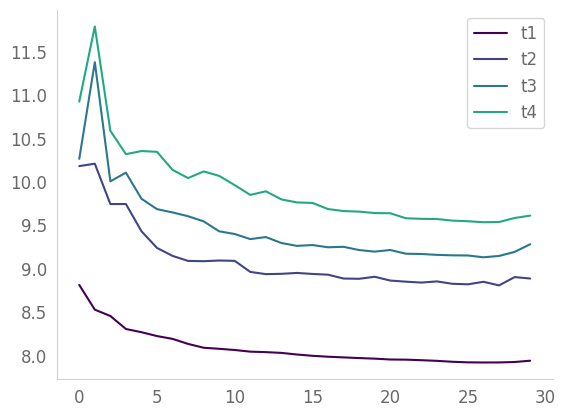

In [21]:
import os
import matplotlib.pyplot as plt

# 假设你已有变量：l_loss 和 exp_dir
plt.plot(l_loss['0:1'], label='t1')
plt.plot(l_loss['1:2'], label='t2')
plt.plot(l_loss['2:3'], label='t3')
plt.plot(l_loss['3:4'], label='t4')
plt.legend()

# 拼接保存路径
save_path = os.path.join(exp_dir, 'emd_train_each_tp.png')
plt.savefig(save_path)

### Test

In [22]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))

<All keys matched successfully>

In [23]:
l_loss, b_loss, g_loss = train(
    f_net, df, groups, optimizer, 1, 
    criterion = criterion, use_cuda = use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out, hold_out=args.hold_out, 
    sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
    sample_with_replacement = args.sample_with_replacement, logger=logger, device=device, best_model_path=exp_dir+'/test_model',stepsize=0.1
)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:1.6942391395568848,relative_mass_now:1.7484250314993701
RME:0.03099125839900495
Otloss:7.91698
total loss:7.91698
epoch_0_1:
relative_mass_pred:1.468749761581421,relative_mass_now:1.376732465350693
RME:0.06683745647509558
Otloss:8.80408
total loss:8.80408
epoch_0_2:
relative_mass_pred:1.6149619817733765,relative_mass_now:1.5392692146157076
RME:0.04917448256545961
Otloss:9.11376
total loss:9.11376
epoch_0_3:
relative_mass_pred:1.515211582183838,relative_mass_now:1.3994120117597648
RME:0.08274873264697419


100%|██████████| 1/1 [00:05<00:00,  5.12s/it]

Otloss:9.53562
total loss:9.53562
New minimum otloss found: 9.535618782043457. Model saved.


In [27]:
# generate plot data
f_net.to('cpu')
generated, trajectories,generated_weights,trajectories_weights = generate_plot_data(
    f_net, df, n_points=400, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3., 4.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0404, 0.0808, 0.1212, 0.1616, 0.2020, 0.2424, 0.2828, 0.3232,
        0.3636, 0.4040, 0.4444, 0.4848, 0.5253, 0.5657, 0.6061, 0.6465, 0.6869,
        0.7273, 0.7677, 0.8081, 0.8485, 0.8889, 0.9293, 0.9697, 1.0101, 1.0505,
        1.0909, 1.1313, 1.1717, 1.2121, 1.2525, 1.2929, 1.3333, 1.3737, 1.4141,
        1.4545, 1.4949, 1.5354, 1.5758, 1.6162, 1.6566, 1.6970, 1.7374, 1.7778,
        1.8182, 1.8586, 1.8990, 1.9394, 1.9798, 2.0202, 2.0606, 2.1010, 2.1414,
        2.1818, 2.2222, 2.2626, 2.3030, 2.3434, 2.3838, 2.4242, 2.4646, 2.5051,
        2.5455, 2.5859, 2.6263, 2.6667, 2.7071, 2.7475, 2.7879, 2.8283, 2.8687,
        2.9091, 2.9495, 2.9899, 3.0303, 3.0707, 3.1111, 3.1515, 3.1919, 3.2323,
        3.2727, 3.3131, 3.3535, 3.3939, 3.4343, 3.4747, 3.5152, 3.5556, 3.5960,
        3.6364, 3.6768, 3.7172, 3.7576, 3.7980, 3.8384, 3.8788, 3.9192, 3.9596,
        4.0000])
<class 'torch.Tensor'>


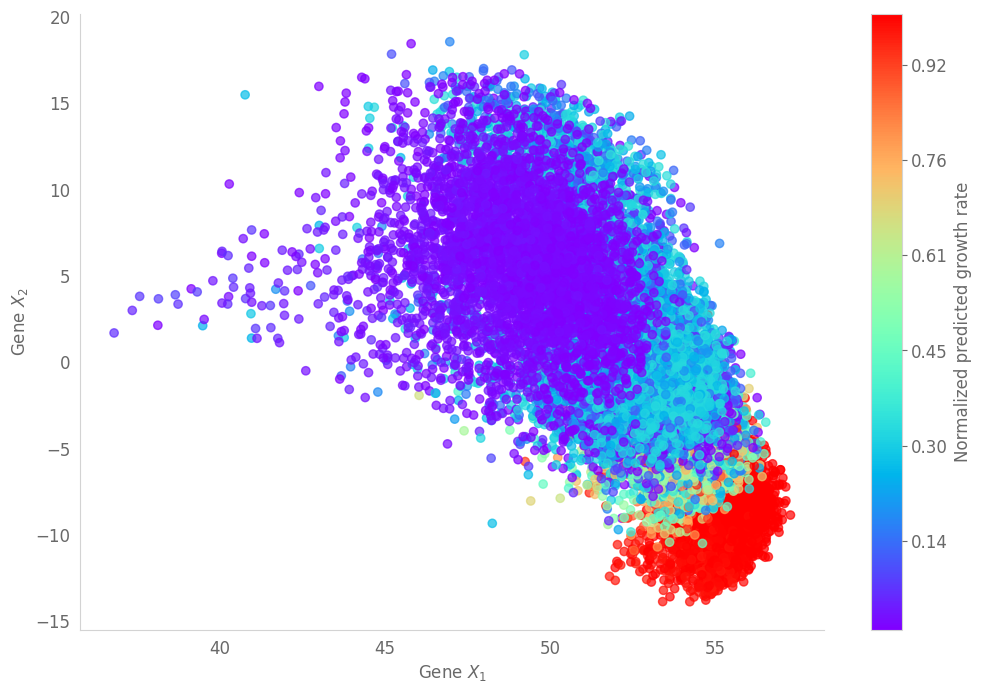

In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 50

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_final.pdf')

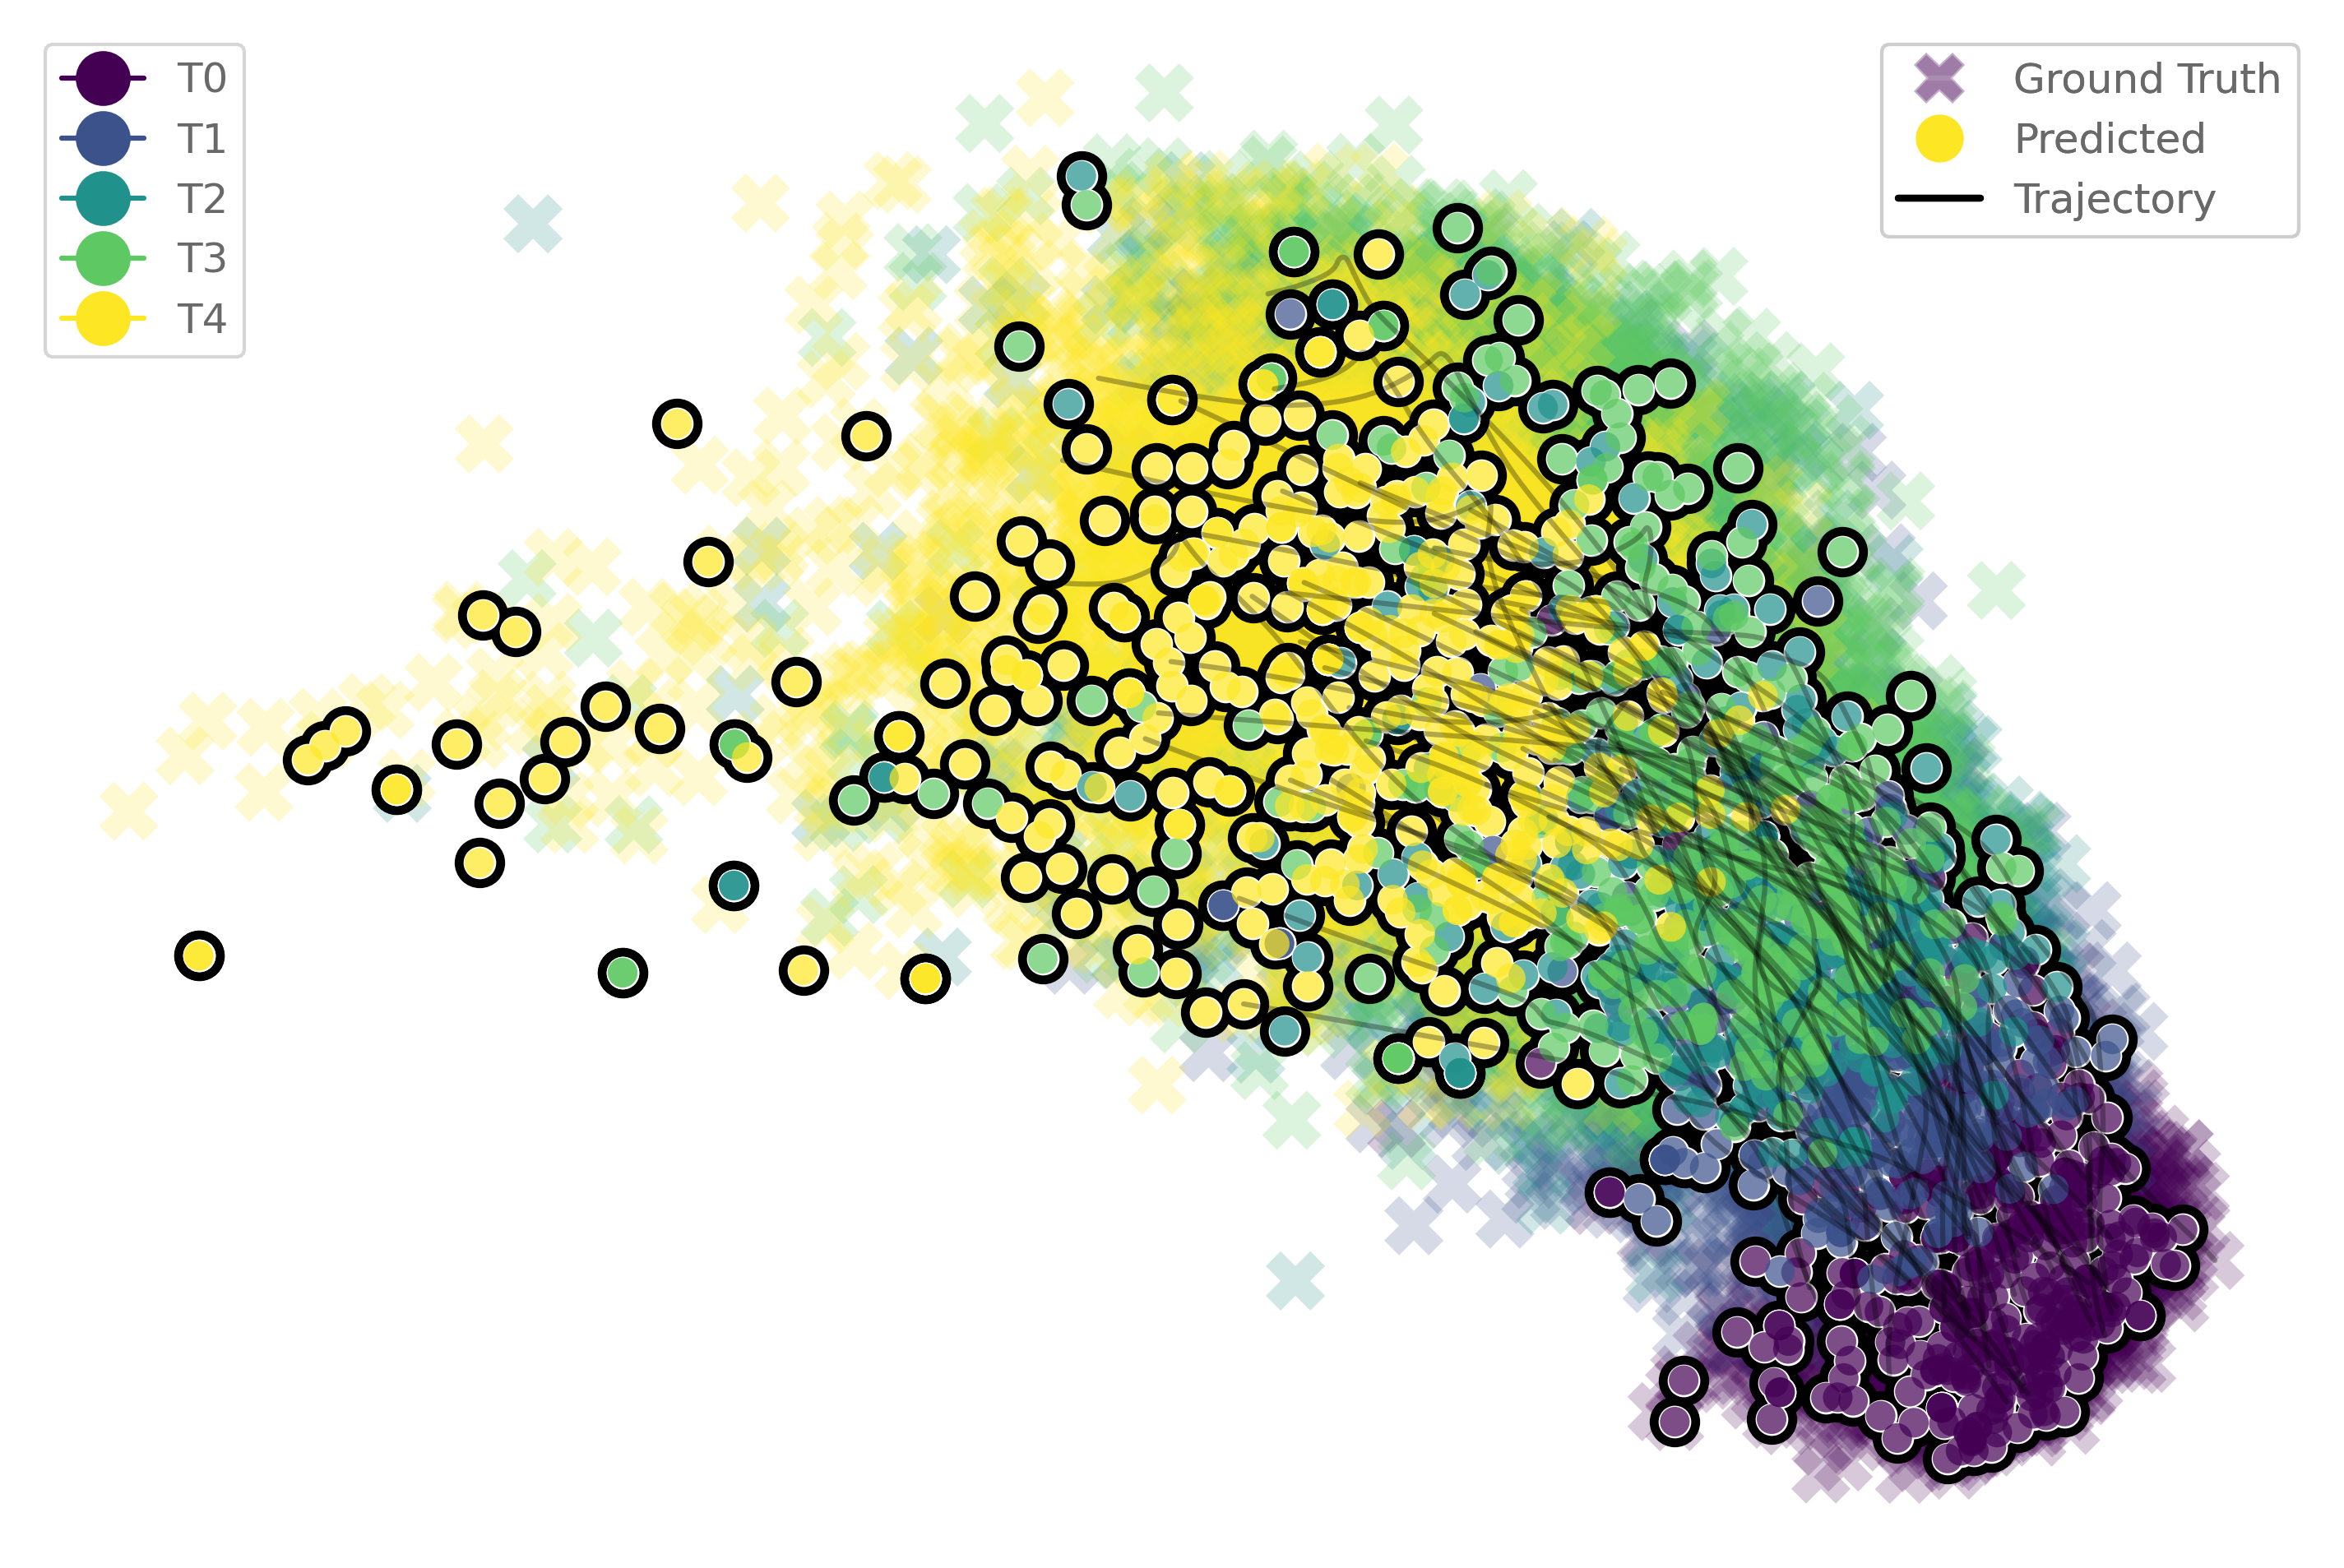

In [28]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_final.png',
    x='x1', y='x2', is_3d=False
)